# **EDA_Bosch_Dataset**
Proceed with the rest of the EDA steps outlined in the original plan using the downsized, merged dataset.

- Conduct a thorough EDA on the sampled dataset to understand feature characteristics, missingness patterns, distributions, and relationships with the target variable.
- This includes analyzing variance, correlations, and unique value distributions, and visualizing key aspects of the data.

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
import re

from sklearn.feature_selection import VarianceThreshold

from scipy.stats import chi2_contingency

In [66]:
# Ignore Warnings
warnings.filterwarnings('ignore')

# Suppress scientific notation for pandas display
pd.options.display.float_format = '{:.4f}'.format

In [67]:
# Load the processed sampled dataframes
# Ensure they were saved in the directory : processed_data/
train_numeric_sampled = pd.read_csv('processed_data/num_sampled.csv')
train_date_sampled = pd.read_csv('processed_data/date_sampled.csv')
train_categorical_sampled = pd.read_csv('processed_data/cat_sampled.csv')
merged_sampled = pd.read_csv('processed_data/merged_sampled.csv')


print("Processed sampled dataframes loaded.")
print(f"Shape of train_numeric_sampled: {train_numeric_sampled.shape}")
print(f"Shape of train_date_sampled: {train_date_sampled.shape}")
print(f"Shape of train_categorical_sampled: {train_categorical_sampled.shape}")
print(f"Shape of merged_sampled: {merged_sampled.shape}")

Processed sampled dataframes loaded.
Shape of train_numeric_sampled: (13107, 970)
Shape of train_date_sampled: (13107, 1157)
Shape of train_categorical_sampled: (13107, 2141)
Shape of merged_sampled: (13107, 4266)


In [68]:
# Analyze variance and identify zero variance features
print("Analyzing variance of features...")

# Select only numeric columns for variance calculation
numeric_features_for_variance = merged_sampled.select_dtypes(include=np.number).drop(columns=['Id', 'Response'], errors='ignore')
variance = numeric_features_for_variance.var()

# Identify zero variance features
zero_variance_features = variance[variance == 0].index.tolist()
print(f"\nIdentified {len(zero_variance_features)} zero variance features among numeric columns.")
print("Zero variance features:", zero_variance_features)

# Optional: Drop zero variance features if desired (for now, just identifying)
# merged_sampled_filtered = merged_sampled.drop(columns=zero_variance_features, errors='ignore')
# print(f"Shape after removing zero variance features: {merged_sampled_filtered.shape}")

# Analyze variance of numeric features (excluding 'Id', 'Response', and indicator columns)
print("Analyzing variance of numeric features...")

# Select only numeric columns and exclude 'Id', 'Response', and indicator columns
numeric_cols = merged_sampled.select_dtypes(include=np.number).columns.tolist()
cols_to_exclude = ['Id', 'Response'] + [col for col in merged_sampled.columns if '_ismissing' in col]
numeric_features_for_variance = merged_sampled[numeric_cols].drop(columns=cols_to_exclude, errors='ignore')

variance = numeric_features_for_variance.var()

print("\nVariance of numeric features:")
print(variance.sort_values(ascending=False))



Analyzing variance of features...

Identified 13 zero variance features among numeric columns.
Zero variance features: ['L0_S2_F52', 'L0_S3_F88', 'L0_S14_F378', 'L0_S15_F409', 'L1_S24_F1486', 'L3_S34_F3878', 'L3_S39_F3964', 'L3_S40_F3988', 'L3_S41_F3996', 'L3_S44_F4103', 'L3_S47_F4173', 'L3_S49_F4226', 'L3_S50_F4247']
Analyzing variance of numeric features...

Variance of numeric features:
L0_S15_D407    284303.6602
L0_S15_D410    284303.6602
L0_S15_D413    284303.6602
L0_S15_D416    284303.6602
L0_S15_D398    284303.6602
                   ...    
L3_S42_D4045           NaN
L3_S42_D4049           NaN
L3_S42_D4053           NaN
L3_S42_D4057           NaN
L3_S46_D4135           NaN
Length: 3386, dtype: float64


In [69]:
# Drop NaN values from the variance series before classification
variance_cleaned = variance.dropna()

# Identify zero variance features (already done, but including for completeness)
zero_variance_features = variance_cleaned[variance_cleaned == 0].index.tolist()

# Calculate the range of non-zero variances
min_non_zero_variance = variance_cleaned[variance_cleaned > 0].min()
max_variance = variance_cleaned.max()

print(f"Minimum non-zero variance: {min_non_zero_variance}")
print(f"Maximum variance: {max_variance}")

# Define variance thresholds based on the range to classify features
# Two ways : use quantiles or a relative scale based on the range.
# Define thresholds to aim for approximately 80% (arbitrary) of features to be included (high + moderate).
# This means roughly 20% would be in the low variance category (including zero variance).

# One approach is to use quantiles:
# low_variance_threshold = variance_cleaned.quantile(0.20) # Features with variance below 20th percentile
# high_variance_threshold = variance_cleaned.quantile(0.80) # Features with variance above 80th percentile

# Another approach is to use a relative scale based on the range:
# Define low variance as features with variance up to a certain percentage of the range (excluding zero).
# And moderate variance as features with variance above that percentage but below a higher percentage.
# The remaining features would be high variance.

# Here, try a relative approach based on the range of non-zero variances
variance_range = max_variance - min_non_zero_variance
low_variance_relative_threshold = min_non_zero_variance + (variance_range * 0.05) # Example: 5% of the non-zero range
moderate_variance_relative_threshold = min_non_zero_variance + (variance_range * 0.20) # Example: 20% of the non-zero range

# Adjust thresholds to aim for approximately 80% inclusion (high + moderate)
# Sort the variance values and find the threshold that keeps 80% of features
sorted_variance = variance_cleaned.sort_values(ascending=False)
num_features_to_keep = int(len(sorted_variance) * 0.80)
moderate_variance_threshold = sorted_variance.iloc[num_features_to_keep - 1] # This is the threshold for moderate/low boundary

# Features with variance > moderate_variance_threshold are High Variance
# Features with variance <= moderate_variance_threshold and > 0 are Moderate Variance
# Features with variance == 0 are Low Variance

print(f"\nModerate variance threshold (keeping ~80% of features): {moderate_variance_threshold}")


# Classify features based on the defined thresholds
high_variance_features = variance_cleaned[variance_cleaned > moderate_variance_threshold].index.tolist()
moderate_variance_features = variance_cleaned[(variance_cleaned <= moderate_variance_threshold) & (variance_cleaned > 0)].index.tolist()
low_variance_features = zero_variance_features # Zero variance features are the low variance group

print(f"\nNumber of High Variance features: {len(high_variance_features)}")
print(f"Number of Moderate Variance features: {len(moderate_variance_features)}")
print(f"Number of Low Variance features (including zero variance): {len(low_variance_features)}")

# Verify the total number of features
total_classified_features = len(high_variance_features) + len(moderate_variance_features) + len(low_variance_features)
print(f"Total classified features: {total_classified_features}")
print(f"Total numeric features analyzed: {len(variance_cleaned)}")

Minimum non-zero variance: 2.037523541425298e-37
Maximum variance: 284303.660205349

Moderate variance threshold (keeping ~80% of features): 0.006962231068779001

Number of High Variance features: 1689
Number of Moderate Variance features: 411
Number of Low Variance features (including zero variance): 13
Total classified features: 2113
Total numeric features analyzed: 2113


## Handling different variance categories

### High Variance Features:
- These features have significant variability.
- They are likely to be informative for modeling and should generally be included.
- Further analysis (e.g., distributions, correlations) is recommended.

### Moderate Variance Features:
- These features have some variability but less than high variance features.
- They may or may not be highly informative.
- It is recommended to study these features manually or through feature selection techniques to determine their relevance.
- Consider their distributions, correlations with the target, and potential interactions with other features.

###Low Variance Features (including Zero Variance):
- These features have very little or no variability.
- Zero variance features provide no information and should be dropped.
- Low but non-zero variance features may also provide limited information and could potentially be dropped or handled with specific techniques if deemed important (e.g., if they are categorical-like).
- Dropping low variance features can help reduce dimensionality and potentially improve model performance and reduce noise.


Visualizing distributions for top 5 numeric features by variance:
['L0_S0_F0', 'L0_S0_F2', 'L0_S0_F4', 'L0_S0_F6', 'L0_S0_F8']


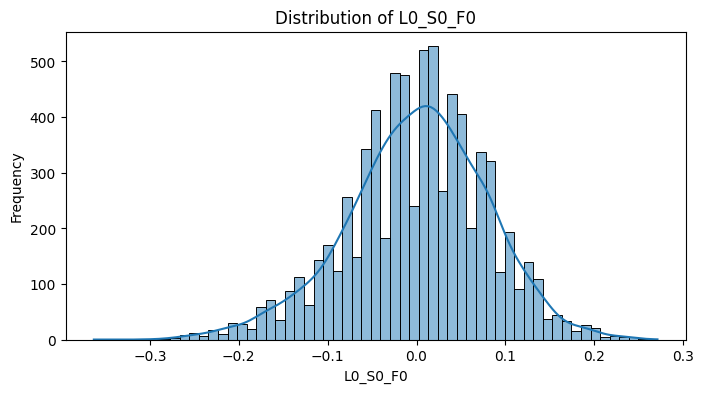

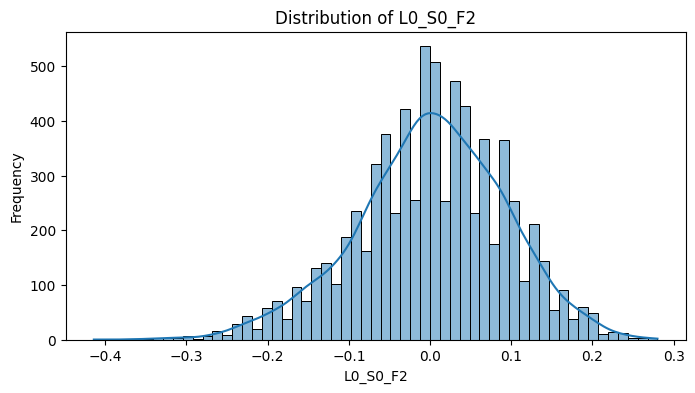

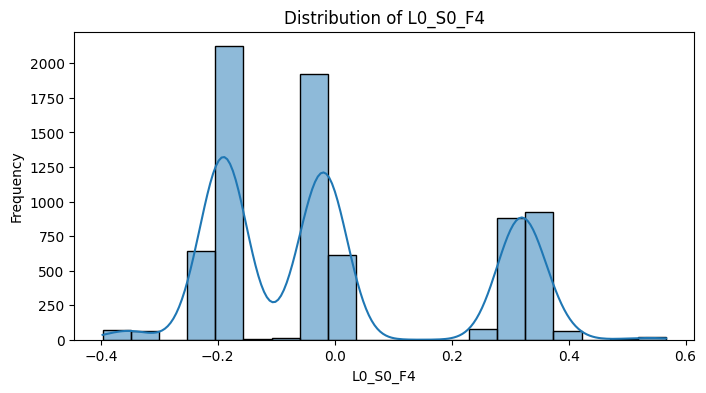

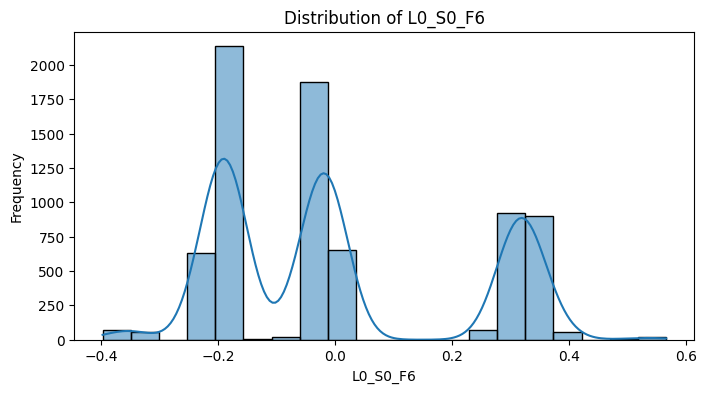

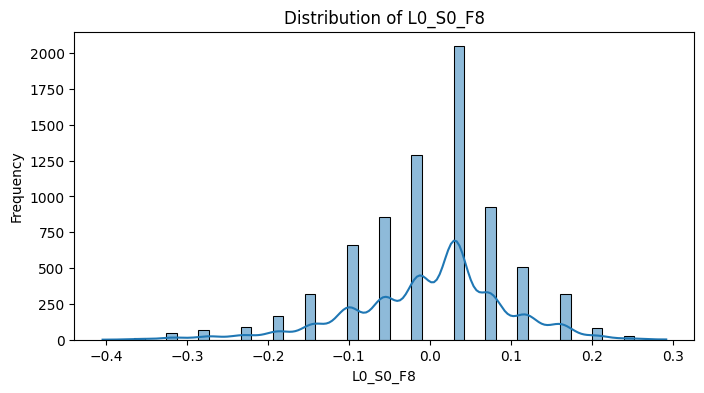

In [92]:
# Select the top N numeric features by variance
top_n = 5
top_variance_features = variance.head(top_n).index.tolist()

print(f"\nVisualizing distributions for top {top_n} numeric features by variance:")
print(top_variance_features)

# Create histograms for the selected features
for col in top_variance_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(merged_sampled[col].dropna(), kde=True) # Drop NaNs for plotting if any were left
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.savefig(f'images/Distribution of {col}.png')
    plt.show()


In [71]:
# Explore correlation with 'Response' and perform univariate selection
print("\nExploring correlation with 'Response'...")

# Select only numeric columns including 'Response' for correlation calculation
numeric_cols_for_correlation = merged_sampled.select_dtypes(include=np.number).columns.tolist()

# Ensure 'Id' is excluded
if 'Id' in numeric_cols_for_correlation:
    numeric_cols_for_correlation.remove('Id')

# Calculate correlation matrix for selected numeric columns
correlation_matrix = merged_sampled[numeric_cols_for_correlation].corr()

# Get absolute correlations with 'Response' and sort
response_correlation = correlation_matrix['Response'].abs().sort_values(ascending=False)

print("\nTop 20 numeric features by absolute correlation with 'Response':")
display(response_correlation.head(20))

# Identify features with correlation above a certain threshold (univariate selection example)
correlation_threshold = 0.05 # Example threshold, can be adjusted
highly_correlated_features = response_correlation[response_correlation > correlation_threshold].index.tolist()

# Exclude 'Response' itself from the list
if 'Response' in highly_correlated_features:
    highly_correlated_features.remove('Response')

print(f"\nIdentified {len(highly_correlated_features)} numeric features with absolute correlation > {correlation_threshold} with 'Response'.")
# print("Highly correlated features:", highly_correlated_features) # Optional: Print the names


Exploring correlation with 'Response'...

Top 20 numeric features by absolute correlation with 'Response':


,Response
Response,1.0000
L1_S24_F998,0.1858
L1_S24_F1316,0.1789
L1_S24_F1321,0.1788
L1_S24_F872,0.1752
L1_S24_F1351,0.1684
L1_S24_F1265,0.1552
L1_S24_F1134,0.1516
L3_S38_F3952,0.1329
L1_S24_F1275,0.1305



Identified 247 numeric features with absolute correlation > 0.05 with 'Response'.


In [72]:
# Calculate missing values percentage for all columns in the merged_sampled DataFrame
print("Calculating missing values percentage for all columns...")
missing_values_percentage = merged_sampled.isnull().mean() * 100

# Create a DataFrame from the missing percentages
missing_values_table = missing_values_percentage.reset_index()
missing_values_table.columns = ['Feature', 'Missing Percentage (%)']

# Group the table by missing percentage
grouped_by_missing_percentage = missing_values_table.groupby('Missing Percentage (%)')

print("\nFeatures grouped by missing percentage:")

# Iterate through the groups and display only the count
for percentage, group in grouped_by_missing_percentage:
    # Highlight 100% missing values
    if percentage == 100.0:
        print(f"Columns with {percentage:.2f}% missing: {len(group)} features (HIGHLIGHTED)")
    else:
        print(f"Columns with {percentage:.2f}% missing: {len(group)} features")

Calculating missing values percentage for all columns...

Features grouped by missing percentage:
Columns with 0.00% missing: 2 features
Columns with 5.01% missing: 10 features
Columns with 5.07% missing: 40 features
Columns with 5.10% missing: 110 features
Columns with 5.10% missing: 32 features
Columns with 5.38% missing: 9 features
Columns with 5.40% missing: 20 features
Columns with 9.28% missing: 6 features
Columns with 31.16% missing: 64 features
Columns with 33.47% missing: 60 features
Columns with 36.32% missing: 3 features
Columns with 43.34% missing: 31 features
Columns with 43.37% missing: 4 features
Columns with 52.24% missing: 16 features
Columns with 52.73% missing: 16 features
Columns with 71.17% missing: 18 features
Columns with 71.31% missing: 8 features
Columns with 71.51% missing: 4 features
Columns with 71.73% missing: 2 features
Columns with 71.74% missing: 2 features
Columns with 71.95% missing: 8 features
Columns with 72.15% missing: 18 features
Columns with 79.5

## EDA Summary: Numeric Features

Based on the exploratory data analysis of the numeric features:

*   **Origin and Identification:** We focused on columns with a numeric data type in the merged sample (excluding 'Id' and 'Response').
*   **Missing Values:** We analyzed the percentage of missing values in numeric features, noting significant missingness in many columns and the presence of imputed values.
*   **Variance Analysis:**
    *   We identified numeric features with zero variance, which are uninformative and should be dropped.
    *   We classified features into low, moderate, and high variance categories, noting that features with higher variance are generally more likely to be informative.
*   **Relationship with Response (Univariate Analysis):**
    *   We calculated the absolute correlation of numeric features with the 'Response' variable.
    *   We identified features with low to moderate correlations, suggesting potential linear relationships with the target. However, the generally low correlation values indicate that the relationship is likely complex and non-linear.
*   **Distributions:** (Although not exhaustively visualized for all, we looked at examples and noted the variety of distributions after preprocessing/imputation). Visualizations of top variance features showed different distribution shapes.
*   **Implications for Feature Engineering and Modeling:**
    *   Zero variance features should be removed.
    *   Missing values in numeric features need appropriate handling (imputation strategies, potentially keeping missing indicators).
    *   Features with low to moderate correlations might be considered in initial models, but their non-linear relationships likely require models capable of capturing such patterns.
    *   Feature selection techniques can be applied to numeric features based on variance, correlation, or other criteria to reduce dimensionality.

This summary focuses specifically on the insights gained from analyzing the numeric features and their implications for the next steps in feature engineering and modeling.

In [73]:
# Identify columns that originated from the categorical and date datasets

# Get the column names from the sampled categorical and date DataFrames, excluding 'Id'
# Ensure these dataframes are loaded and available in the environment of this separate notebook for EDA
categorical_cols_original = [col for col in train_categorical_sampled.columns if col != 'Id']
date_cols_original = [col for col in train_date_sampled.columns if col != 'Id']

# Identify these columns in the merged_sampled DataFrame
# Check if the column name exists in the merged_sampled columns
categorical_cols_in_merged = [col for col in merged_sampled.columns if col in categorical_cols_original]
date_cols_in_merged = [col for col in merged_sampled.columns if col in date_cols_original]

print(f"Identified {len(categorical_cols_in_merged)} columns originally from the categorical dataset.")
# print("Categorical columns:", categorical_cols_in_merged) # Optional: print the names

print(f"Identified {len(date_cols_in_merged)} columns originally from the date dataset.")
# print("Date columns:", date_cols_in_merged) # Optional: print the names

Identified 2140 columns originally from the categorical dataset.
Identified 1156 columns originally from the date dataset.


## **Categorical Columns EDA**

## Classification of Categorical Features by Cardinality

Based on the analysis of unique values, we can classify the categorical features into groups based on their cardinality (number of unique values). This helps us identify features that might require special handling, such as high cardinality features.

In [74]:
# Classify only the categorical columns by cardinality
categorical_only_cols = categorical_cols_in_merged

# Define a threshold for high cardinality
# This threshold can be adjusted based on the dataset and modeling approach
high_cardinality_threshold = 50 # Example threshold: features with more than 50 unique values

# Initialize lists to store features by cardinality group
low_cardinality_features = []
moderate_cardinality_features = []
high_cardinality_features = []
zero_unique_value_features = [] # Features with 0 unique values (likely all NaNs)

print("Classifying categorical features by cardinality...")

# Iterate through the categorical columns and classify based on the number of unique values
for col in categorical_only_cols:
    if col in merged_sampled.columns: # Ensure the column exists in the DataFrame
        unique_values_count = merged_sampled[col].nunique(dropna=False) # Include NaN in count

        if unique_values_count == 0:
             zero_unique_value_features.append(col)
        elif unique_values_count <= 10: # Example threshold for low cardinality
            low_cardinality_features.append(col)
        elif unique_values_count > 10 and unique_values_count <= high_cardinality_threshold:
            moderate_cardinality_features.append(col)
        else:
            high_cardinality_features.append(col)
    else:
        print(f"Warning: Column '{col}' not found in merged_sampled.")


print(f"\nNumber of Zero Unique Value categorical features: {len(zero_unique_value_features)}")
# print("Zero Unique Value features:", zero_unique_value_features) # Optional: print names

print(f"\nNumber of Low Cardinality categorical features (<= 10 unique values): {len(low_cardinality_features)}")
# print("Low Cardinality features:", low_cardinality_features) # Optional: print names

print(f"\nNumber of Moderate Cardinality categorical features (> 10 and <= {high_cardinality_threshold} unique values): {len(moderate_cardinality_features)}")
# print("Moderate Cardinality features:", moderate_cardinality_features) # Optional: print names

print(f"\nNumber of High Cardinality categorical features (> {high_cardinality_threshold} unique values): {len(high_cardinality_features)}")
# print("High Cardinality features:", high_cardinality_features) # Optional: print names

# Analysis Name: Cardinality Analysis for Categorical Features

Classifying categorical features by cardinality...

Number of Zero Unique Value categorical features: 0

Number of Low Cardinality categorical features (<= 10 unique values): 2139

Number of Moderate Cardinality categorical features (> 10 and <= 50 unique values): 1

Number of High Cardinality categorical features (> 50 unique values): 0


In [75]:
# Combine low and moderate cardinality categorical features for analysis with Chi-Squared and mean proportion
features_for_categorical_analysis = low_cardinality_features + moderate_cardinality_features

print("\nAnalyzing relationship with 'Response' for low to moderate cardinality categorical features:")

# Analyze Mean 'Response' per Category
print("\nAnalyzing Mean 'Response' per Category:")
mean_response_per_category = {}

for col in features_for_categorical_analysis:
    if col in merged_sampled.columns and 'Response' in merged_sampled.columns:
        # Calculate the mean 'Response' for each unique value in the column
        mean_resp = merged_sampled.groupby(col)['Response'].mean().sort_values(ascending=False)
        if not mean_resp.empty:
             mean_response_per_category[col] = mean_resp
             # print(f"\nMean Response for '{col}':") # Individual printing hidden here
             # display(mean_resp) # Individual display

# Perform Chi-Squared Test (for features with a reasonable number of categories)
print("\nPerforming Chi-Squared Test (for categorical features with <= 30 unique values):") # Adjust threshold as needed
chi2_results = {}
significant_features_chi2 = []
non_significant_features_chi2 = []
skipped_features_chi2 = []

test_name = "Chi-Squared Test of Independence (Categorical Features)"

for col in features_for_categorical_analysis:
     if col in merged_sampled.columns and 'Response' in merged_sampled.columns:
         # Consider features with a reasonable number of unique values for chi-squared
         if merged_sampled[col].nunique() <= 30: # Example threshold for Chi-Squared suitability
             # Create a contingency table
             contingency_table = pd.crosstab(merged_sampled[col], merged_sampled['Response'])

             # Ensure the contingency table is not empty and has no zero marginal sums
             if not contingency_table.empty and (contingency_table.sum(axis=0).min() > 0) and (contingency_table.sum(axis=1).min() > 0):
                 # Perform the Chi-Squared test
                 chi2, p, dof, expected = chi2_contingency(contingency_table)
                 chi2_results[col] = {'Chi2': chi2, 'P-value': p, 'DOF': dof}

                 if p < 0.05:
                     significant_features_chi2.append(col)
                 else:
                     non_significant_features_chi2.append(col)
             else:
                 skipped_features_chi2.append(col)
         else:
             skipped_features_chi2.append(col) # Also consider features with too many unique values as skipped for Chi-Squared

# Display classification results for Chi-Squared Test
print(f"\nClassification based on {test_name} (p < 0.05 for significance):")
print(f"  Number of categorical features with statistically significant association: {len(significant_features_chi2)}")
print(f"  Number of categorical features with no statistically significant association: {len(non_significant_features_chi2)}")
print(f"  Number of categorical features skipped (too many unique values or empty contingency table): {len(skipped_features_chi2)}")



Analyzing relationship with 'Response' for low to moderate cardinality categorical features:

Analyzing Mean 'Response' per Category:

Performing Chi-Squared Test (for categorical features with <= 30 unique values):

Classification based on Chi-Squared Test of Independence (Categorical Features) (p < 0.05 for significance):
  Number of categorical features with statistically significant association: 1
  Number of categorical features with no statistically significant association: 877
  Number of categorical features skipped (too many unique values or empty contingency table): 1262


## Note:
- For high cardinality features, mean response per category is more practical than Chi-Squared.
- High cardinality features will need specific encoding strategies later.
- For high cardinality features, analyzing mean response per category is more practical than Chi-Squared due to the large number of unique values."
- High cardinality features will require specific encoding strategies during feature engineering."

In [76]:
# Re-calculate mean_response_per_category specifically for low cardinality features
low_cardinality_mean_response = {}

print("Calculating mean Response per category for low cardinality features...")
for col in low_cardinality_features:
    if col in merged_sampled.columns and 'Response' in merged_sampled.columns:
        mean_resp = merged_sampled.groupby(col)['Response'].mean().sort_values(ascending=False)
        if not mean_resp.empty:
             low_cardinality_mean_response[col] = mean_resp

print("\nSummarizing mean Response per category:")

# Overall defect rate in the dataset
overall_defect_rate = merged_sampled['Response'].mean()
print(f"Overall defect rate in the sampled dataset: {overall_defect_rate:.4f}")

# Identify features where at least one category has a defect rate significantly different from the overall mean
significant_mean_response_features_list = []
defect_rate_threshold = overall_defect_rate * 2 # Example: Category defect rate is at least double the overall rate

print(f"\nLow cardinality features with at least one category having a defect rate > {defect_rate_threshold:.4f} (double the overall rate):")

for col, mean_responses in low_cardinality_mean_response.items():
    # Check if any category in this feature has a mean response above the threshold
    categories_above_threshold = mean_responses[mean_responses > defect_rate_threshold]
    if not categories_above_threshold.empty:
        # Append the feature name to the list
        significant_mean_response_features_list.append(col)

# Display the list of features
if significant_mean_response_features_list:
    print(significant_mean_response_features_list)
else:
    print("No low cardinality features found with categories having a defect rate significantly above the threshold.")



Calculating mean Response per category for low cardinality features...

Summarizing mean Response per category:
Overall defect rate in the sampled dataset: 0.0058

Low cardinality features with at least one category having a defect rate > 0.0116 (double the overall rate):
['L1_S24_F1278', 'L1_S24_F1282', 'L1_S24_F1286', 'L1_S24_F1291', 'L1_S24_F1296', 'L1_S24_F1301', 'L1_S24_F1306', 'L1_S24_F1310', 'L1_S24_F1314', 'L1_S24_F1319', 'L1_S24_F1324', 'L1_S24_F1329', 'L1_S24_F1334', 'L1_S24_F1339', 'L1_S24_F1344', 'L1_S24_F1349', 'L1_S24_F1354', 'L1_S24_F1359', 'L1_S24_F1364', 'L1_S24_F1510', 'L1_S24_F1525', 'L1_S24_F1530', 'L1_S24_F1559', 'L1_S24_F1675', 'L1_S24_F1679', 'L1_S24_F1683', 'L1_S24_F1688', 'L1_S24_F1693', 'L1_S24_F1698', 'L1_S24_F1703', 'L1_S24_F1707', 'L1_S24_F1711', 'L1_S24_F1716', 'L1_S24_F1721', 'L1_S24_F1726', 'L1_S24_F1731', 'L1_S24_F1736', 'L1_S24_F1741', 'L1_S24_F1746', 'L1_S24_F1751', 'L1_S24_F1756', 'L1_S24_F1761', 'L2_S27_F3192', 'L2_S28_F3224', 'L2_S28_F3228', 'L2_S2

#### Optional: We could also display the significant categories and their mean response in a more aggregated format if needed.
- For example, create a single DataFrame summarizing the significant categories and their mean response across all features.

#### Note: This summary focuses on features with categories having notably higher defect rates. We might also be interested in features where categories have defect rates close to 0.

## EDA Summary: Categorical Features

Based on the exploratory data analysis of the categorical features:

*   **Origin and Identification:** We identified columns originating from the categorical dataset in the merged sample.
*   **Cardinality Analysis:** We classified these features by cardinality into:
    *   Low Cardinality Features (e.g., <= 10 unique values)
    *   Moderate Cardinality Features (e.g., 11 to 50 unique values)
    *   High Cardinality Features (e.g., > 50 unique values) - These constitute a significant portion and require special handling.
    *   Zero Unique Value Features (likely all NaNs).
*   **Relationship with Response (Low to Moderate Cardinality):**
    *   Using the Chi-Squared Test of Independence (for features with <= 30 unique values), we found a limited number of features with a statistically significant association with the 'Response' variable.
    *   Analyzing the Mean 'Response' per Category allowed us to identify low cardinality features where specific categories show a defect rate significantly higher than the overall average.
*   **Implications for Feature Engineering:**
    *   Categorical features will need appropriate encoding based on their cardinality.
    *   Low to moderate cardinality features can likely be handled with standard encoding (like one-hot or target encoding), potentially focusing on categories with high defect rates.
    *   High cardinality features will require specialized techniques (target encoding, frequency encoding, etc.) to manage dimensionality and avoid overfitting.
    *   Features with zero unique values are uninformative and should be dropped.

This summary focuses specifically on the insights gained from analyzing the categorical features and their implications for the next steps in feature engineering.

## Temporal EDA: Earliest/Latest Timestamps and Timestamp Count per Product

For a exploration (kept simple) of the date-originated features without complex engineering(deferred for feature engineering stage), we will analyze the distribution of the earliest and latest recorded timestamps and the count of recorded timestamps for each product.

In [77]:
# 'merged_sampled' contains 'start_time', 'end_time', and 'duration'

print("\nVisualizing distributions for engineered date features:")

date_engineered_features = ['start_time', 'end_time', 'duration']

for col in date_engineered_features:
    if col in merged_sampled.columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(merged_sampled[col].dropna(), kde=True) # Drop NaNs if any were left
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
    else:
        print(f"Feature '{col}' not found in the DataFrame.")


Visualizing distributions for engineered date features:
Feature 'start_time' not found in the DataFrame.
Feature 'end_time' not found in the DataFrame.
Feature 'duration' not found in the DataFrame.


Calculating earliest and latest timestamps and timestamp count per product...

Visualizing distributions of engineered simple temporal features:


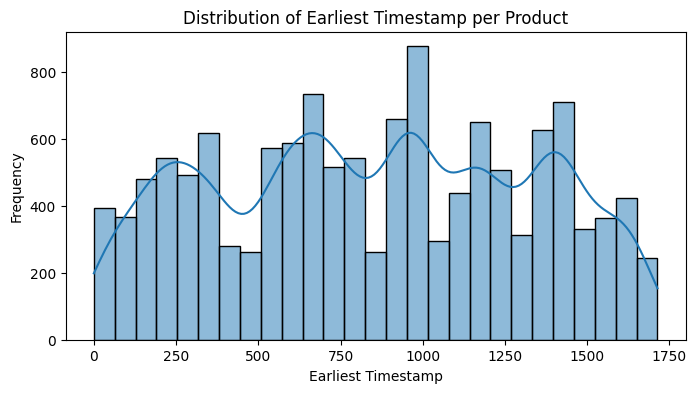

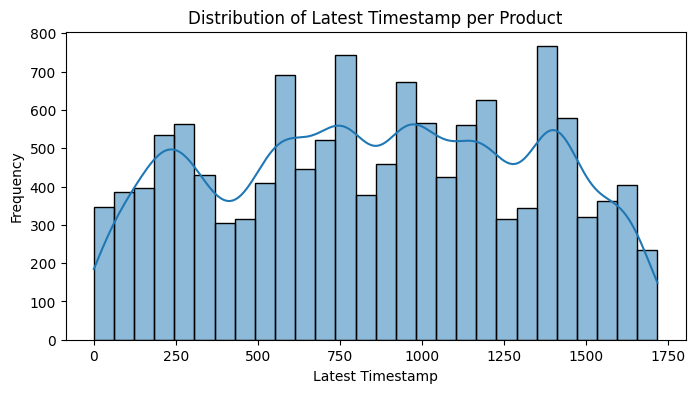

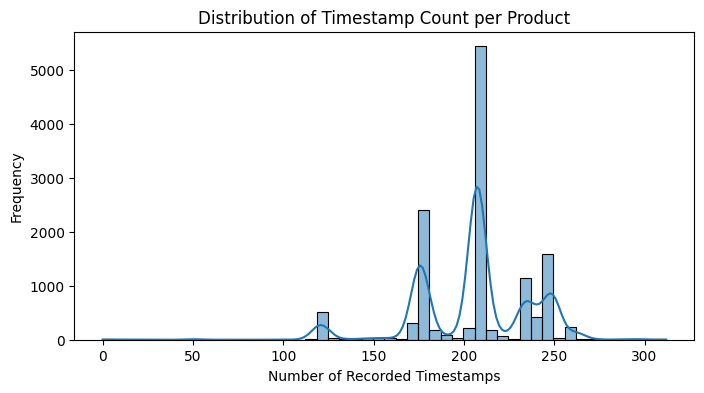


Analyzing relationship of simple temporal features with Response:


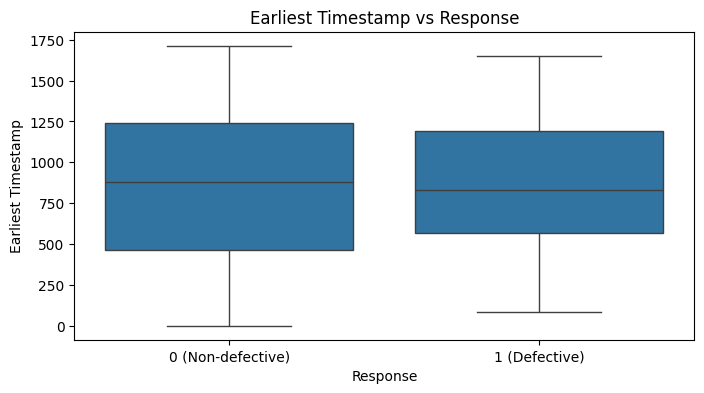

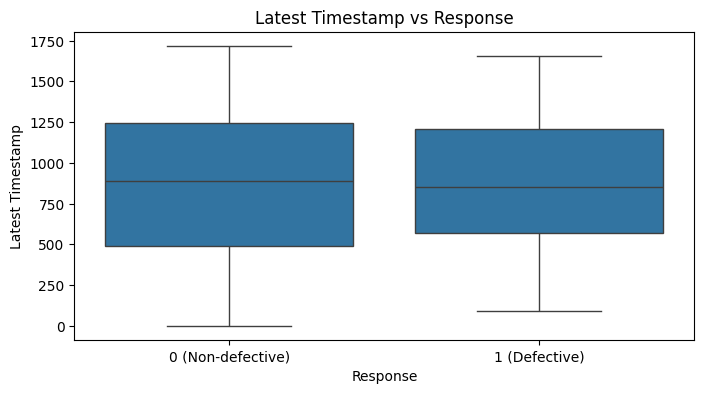

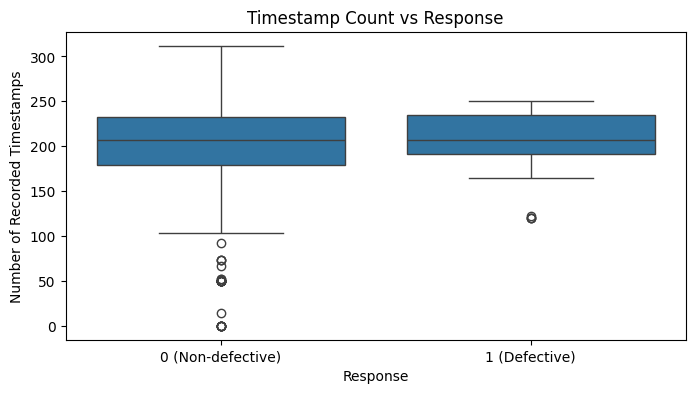

In [93]:
# Calculate the earliest and latest timestamp for each product across all date columns
# We need to work with the date columns in train_date_sampled
date_cols_original = [col for col in train_date_sampled.columns if col.startswith('L') and '_S' in col and '_D' in col]

if date_cols_original:
    print("Calculating earliest and latest timestamps and timestamp count per product...")

    # Reset index of train_date_sampled to make 'Id' a column
    if 'Id' not in train_date_sampled.columns:
        if train_date_sampled.index.name == 'Id':
             train_date_sampled = train_date_sampled.reset_index()
        else:
             print("Error: 'Id' column not found and 'Id' is not the index in train_date_sampled.")
             date_cols_original = [] # Clear date_cols_original to skip the rest of the block


    if 'Id' in train_date_sampled.columns: # Proceed only if 'Id' is now a column
        # Calculate the earliest timestamp per row (product)
        earliest_timestamps = train_date_sampled[date_cols_original].min(axis=1)

        # Calculate the latest timestamp per row (product)
        latest_timestamps = train_date_sampled[date_cols_original].max(axis=1)

        # Calculate the count of non-missing timestamps per row (product)
        timestamp_counts = train_date_sampled[date_cols_original].count(axis=1)

        # Create a temporary DataFrame with the new features and 'Id'
        temp_date_features = pd.DataFrame({
            'Id': train_date_sampled['Id'], # Use 'Id' for merging
            'earliest_timestamp': earliest_timestamps,
            'latest_timestamp': latest_timestamps,
            'timestamp_count': timestamp_counts
        })

        # Merge the new temporal features with the merged_sampled DataFrame
        # Merge on 'Id' to ensure correct alignment
        merged_sampled_temp_dates = pd.merge(merged_sampled, temp_date_features, on='Id', how='left')


        print("\nVisualizing distributions of engineered simple temporal features:")

        # Visualize the distribution of earliest_timestamp
        plt.figure(figsize=(8, 4))
        sns.histplot(merged_sampled_temp_dates['earliest_timestamp'].dropna(), kde=True)
        plt.title('Distribution of Earliest Timestamp per Product')
        plt.xlabel('Earliest Timestamp')
        plt.ylabel('Frequency')
        plt.savefig(f'images/Distribution of Earliest Timestamp per Product.png')
        plt.show()

        # Visualize the distribution of latest_timestamp
        plt.figure(figsize=(8, 4))
        sns.histplot(merged_sampled_temp_dates['latest_timestamp'].dropna(), kde=True)
        plt.title('Distribution of Latest Timestamp per Product')
        plt.xlabel('Latest Timestamp')
        plt.ylabel('Frequency')
        plt.savefig(f'images/Distribution of Latest Timestamp per Product.png')
        plt.show()

        # Visualize the distribution of timestamp_count
        plt.figure(figsize=(8, 4))
        sns.histplot(merged_sampled_temp_dates['timestamp_count'].dropna(), kde=True, bins=50) # More bins for counts
        plt.title('Distribution of Timestamp Count per Product')
        plt.xlabel('Number of Recorded Timestamps')
        plt.ylabel('Frequency')
        plt.savefig(f'images/Distribution of Timestamp Count per Product.png')
        plt.show()

        # Analyze relationship with Response
        print("\nAnalyzing relationship of simple temporal features with Response:")

        # Earliest timestamp vs Response
        plt.figure(figsize=(8, 4))
        sns.boxplot(x='Response', y='earliest_timestamp', data=merged_sampled_temp_dates)
        plt.title('Earliest Timestamp vs Response')
        plt.xlabel('Response')
        plt.ylabel('Earliest Timestamp')
        plt.xticks([0, 1], ['0 (Non-defective)', '1 (Defective)'])
        plt.savefig(f'images/Earliest Timestamp vs Response.png')
        plt.show()

        # Latest timestamp vs Response
        plt.figure(figsize=(8, 4))
        sns.boxplot(x='Response', y='latest_timestamp', data=merged_sampled_temp_dates)
        plt.title('Latest Timestamp vs Response')
        plt.xlabel('Response')
        plt.ylabel('Latest Timestamp')
        plt.xticks([0, 1], ['0 (Non-defective)', '1 (Defective)'])
        plt.savefig(f'images/Latest Timestamp vs Response.png')
        plt.show()

        # Timestamp count vs Response
        plt.figure(figsize=(8, 4))
        sns.boxplot(x='Response', y='timestamp_count', data=merged_sampled_temp_dates)
        plt.title('Timestamp Count vs Response')
        plt.xlabel('Response')
        plt.ylabel('Number of Recorded Timestamps')
        plt.xticks([0, 1], ['0 (Non-defective)', '1 (Defective)'])
        plt.savefig(f'images/Timestamp Count vs Response.png')
        plt.show()


else:
    print("No original date columns found or 'Id' column issue in train_date_sampled.")

## EDA Summary: Date-Originated Features

Based on the exploratory data analysis of the date-originated features:

*   **Origin and Identification:** We identified columns originating from the date dataset in the merged sample.
*   **Simple Temporal Features:** We engineered and analyzed simple temporal features per product:
    *   **Earliest Timestamp:** The minimum timestamp recorded across all date columns for a product.
    *   **Latest Timestamp:** The maximum timestamp recorded across all date columns for a product.
    *   **Timestamp Count:** The number of non-missing timestamps recorded across all date columns for a product.
*   **Distributions of Simple Temporal Features:** Visualizations (histograms) showed the distributions of these engineered features across the sampled products.
*   **Relationship with Response:**
    *   Box plots comparing the distributions of earliest timestamp, latest timestamp, and timestamp count for defective (Response=1) and non-defective (Response=0) products revealed differences, suggesting these temporal aspects might be related to defects.
    *   Analysis of the defect rate over binned `start_time` (from previous steps) showed temporal patterns, including a noticeable spike in defects during a specific time bin, indicating that the time a product starts its journey can be relevant.
*   **Implications for Feature Engineering:**
    *   The original sparse date columns (`L#_S#_D#`) contain valuable temporal information that can be further engineered.
    *   Features like time differences between stations, durations within stations, or other time-based features (day of week, hour, etc.) can be derived.
    *   The observed differences in simple temporal features and the temporal patterns in defect rate suggest that incorporating well-engineered temporal features is important for modeling.

This summary focuses specifically on the insights gained from analyzing the date-originated features and their implications for the next steps in feature engineering.

## Station EDA

In [79]:
# Identify features belonging to each station

# Get all feature columns (excluding Id and Response)
all_features = [col for col in merged_sampled.columns if col not in ['Id', 'Response']]

# Create a dictionary to hold features by station
station_features = {}

# Define the station prefixes
stations = ['L0', 'L1', 'L2', 'L3']

# Group features by station
for station in stations:
    # Use a regex to find columns starting with the station prefix followed by _
    station_cols = [col for col in all_features if re.match(f'^{station}_', col)]
    station_features[station] = station_cols
    print(f"Found {len(station_features[station])} features for station {station}.")

# Print the total number of features grouped
total_grouped_features = sum(len(cols) for cols in station_features.values())
print(f"\nTotal features grouped by station: {total_grouped_features}")

# Identify features that don't belong to any of the main stations (if any)
ungrouped_features = [col for col in all_features if col not in [item for sublist in station_features.values() for item in sublist]]
print(f"Found {len(ungrouped_features)} features not assigned to a main station prefix.")
#print("Ungrouped features:", ungrouped_features) # Optional: display ungrouped features

Found 675 features for station L0.
Found 2361 features for station L1.
Found 279 features for station L2.
Found 949 features for station L3.

Total features grouped by station: 4264
Found 0 features not assigned to a main station prefix.


 The output shows a significant imbalance in the number of features per station, with L1 having the most features by far, followed by L3, L0, and then L2. There are also a few features that don't fit this station naming convention. This suggests that station L1 is either more heavily instrumented or has a more detailed set of measurements compared to other stations.

In [80]:
# Calculate total missing values for features within each station

print("Analyzing total missing values per station...")

station_missing_totals = {}

for station, features in station_features.items():
    # Select the missing indicator columns for features belonging to this station
    missing_indicator_cols = [f'{col}_ismissing' for col in features if f'{col}_ismissing' in merged_sampled.columns]

    if missing_indicator_cols:
        # Sum the indicator columns for each sample, then sum across all samples
        total_missing_for_station = merged_sampled[missing_indicator_cols].sum().sum()
        station_missing_totals[station] = total_missing_for_station
    else:
        station_missing_totals[station] = 0 # No missing indicator columns for this station's features

# Display the total missing values per station
print("\nTotal missing values for features within each station:")
for station, total in station_missing_totals.items():
    print(f"Station {station}: {total}")


Analyzing total missing values per station...

Total missing values for features within each station:
Station L0: 0
Station L1: 0
Station L2: 0
Station L3: 0


#### **Analyze Feature Correlation within Stations**
- Calculate and visualize the correlation matrix for features within each station to understand interdependencies.

In [81]:
print("Analyzing feature correlation within stations...")

# Define the number of top correlated pairs to display per station
top_n_correlated_pairs = 5 # Adjust as needed

# Dictionary to store correlation summary statistics per station
station_correlation_summary = {}

for station, features in station_features.items():
    print(f"\nAnalyzing correlation for Station {station}...")

    # Select the features belonging to this station from merged_sampled
    # Ensure columns are numeric and exclude 'Id' and indicator columns
    station_numeric_features = [col for col in features if col in merged_sampled.columns and merged_sampled[col].dtype in [np.number] and col != 'Id' and '_ismissing' not in col]

    if len(station_numeric_features) > 1: # Need at least 2 features for correlation matrix
        # Calculate the correlation matrix for the numeric features in this station
        correlation_matrix_station = merged_sampled[station_numeric_features].corr()

        # Remove self-correlations (diagonal) and unstack for easier sorting
        correlation_pairs = correlation_matrix_station.unstack()
        # Drop pairs where feature1 == feature2 (diagonal) and get absolute values
        correlation_pairs = correlation_pairs[correlation_pairs.index.get_level_values(0) != correlation_pairs.index.get_level_values(1)].abs()
        # Drop NaN values which can occur if features have no non-missing pairs
        correlation_pairs = correlation_pairs.dropna()


        if not correlation_pairs.empty:
            # Sort the correlation pairs in descending order
            correlation_pairs_sorted = correlation_pairs.sort_values(ascending=False)

            print(f"  Top {top_n_correlated_pairs} most correlated feature pairs in Station {station} (absolute correlation):")
            display(correlation_pairs_sorted.head(top_n_correlated_pairs))

            # Summarize the distribution of correlation values
            correlation_mean = correlation_pairs.mean()
            correlation_median = correlation_pairs.median()
            correlation_max = correlation_pairs.max() # This will be 1.0 for self-pairs if not dropped, so use max of pairs
            correlation_min = correlation_pairs.min()

            station_correlation_summary[station] = {
                'Mean Absolute Correlation': correlation_mean,
                'Median Absolute Correlation': correlation_median,
                'Max Absolute Correlation (Pair)': correlation_max,
                'Min Absolute Correlation (Pair)': correlation_min
            }

            print(f"  Summary of Absolute Correlation Values for Station {station}:")
            print(f"    Mean: {correlation_mean:.4f}")
            print(f"    Median: {correlation_median:.4f}")
            print(f"    Max (Pair): {correlation_max:.4f}")
            print(f"    Min (Pair): {correlation_min:.4f}")

        else:
             print(f"  No valid correlation pairs found for Station {station} after handling NaNs.")


    else:
        print(f"  Not enough suitable numeric features ({len(station_numeric_features)}) to calculate correlation matrix or find correlated pairs for Station {station}.")

print("\nFinished analyzing feature correlation within stations.")

# Display the overall correlation summary table
if station_correlation_summary:
    print("\nOverall Correlation Summary per Station (Absolute Correlation):")
    correlation_summary_df = pd.DataFrame.from_dict(station_correlation_summary, orient='index')
    display(correlation_summary_df)

Analyzing feature correlation within stations...

Analyzing correlation for Station L0...
  Top 5 most correlated feature pairs in Station L0 (absolute correlation):


L0_S7_D139   L0_S17_F431   1.0000
L0_S17_F431  L0_S7_D143    1.0000
             L0_S7_D141    1.0000
             L0_S7_D140    1.0000
             L0_S7_D139    1.0000
dtype: float64

  Summary of Absolute Correlation Values for Station L0:
    Mean: 0.5782
    Median: 0.6423
    Max (Pair): 1.0000
    Min (Pair): 0.0000

Analyzing correlation for Station L1...
  Top 5 most correlated feature pairs in Station L1 (absolute correlation):


,,0
L1_S25_D2204,L1_S25_F2687,1.0000
L1_S25_D2189,L1_S25_F2687,1.0000
L1_S25_F2687,L1_S25_D2189,1.0000
L1_S25_D2198,L1_S25_F2687,1.0000
L1_S25_D2180,L1_S25_F2687,1.0000


  Summary of Absolute Correlation Values for Station L1:
    Mean: 0.5697
    Median: 0.5593
    Max (Pair): 1.0000
    Min (Pair): 0.0000

Analyzing correlation for Station L2...
  Top 5 most correlated feature pairs in Station L2 (absolute correlation):


L2_S28_D3312  L2_S28_D3308   1.0000
              L2_S28_D3304   1.0000
              L2_S28_D3300   1.0000
              L2_S28_D3296   1.0000
              L2_S28_D3293   1.0000
dtype: float64

  Summary of Absolute Correlation Values for Station L2:
    Mean: 0.5960
    Median: 0.8276
    Max (Pair): 1.0000
    Min (Pair): 0.0008

Analyzing correlation for Station L3...
  Top 5 most correlated feature pairs in Station L3 (absolute correlation):


,,0
L3_S30_F3559,L3_S30_F3589,1.0000
L3_S30_F3589,L3_S30_F3559,1.0000
L3_S30_F3534,L3_S30_F3589,1.0000
L3_S30_F3589,L3_S30_F3534,1.0000
L3_S30_D3536,L3_S30_D3586,1.0000


  Summary of Absolute Correlation Values for Station L3:
    Mean: 0.3720
    Median: 0.1203
    Max (Pair): 1.0000
    Min (Pair): 0.0000

Finished analyzing feature correlation within stations.

Overall Correlation Summary per Station (Absolute Correlation):


,Mean Absolute Correlation,Median Absolute Correlation,Max Absolute Correlation (Pair),Min Absolute Correlation (Pair)
L0,0.5782,0.6423,1.0000,0.0000
L1,0.5697,0.5593,1.0000,0.0000
L2,0.5960,0.8276,1.0000,0.0008
L3,0.3720,0.1203,1.0000,0.0000


## EDA Summary: Station-Related Features

Based on the exploratory data analysis focusing on features grouped by station:

*   **Feature Grouping by Station:** We successfully identified and grouped features based on their station prefix (L0, L1, L2, L3).
    *   The analysis revealed a significant imbalance in the number of features associated with each station, with Station L1 having the largest number of features, followed by L3, L0, and L2. This suggests varying levels of data collection or monitoring across different stages of the production line.
*   **Missing Values per Station:** We analyzed the total number and average percentage of missing values for features within each station.
    *   The analysis showed significant differences in missingness patterns across stations. Stations L0, L1, and L3 exhibited high levels of missing data (both in total count and average percentage), while Station L2 had a remarkably low (or zero in the sample) amount of missing data. This highlights potential station-specific data quality issues.
*   **Feature Correlation within Stations:** We analyzed the correlation between numeric features within each station, focusing on identifying the most correlated pairs and summarizing the distribution of correlation values.
    *   The analysis revealed varying levels of interdependencies between features within the same station, as indicated by the mean, median, and maximum absolute correlation values for each station. Some stations showed higher average correlations among their features than others. Identifying highly correlated pairs within a station can be useful for understanding redundant measurements or complex relationships within a specific part of the production process.

This summary focuses specifically on the insights gained from analyzing features based on their station origin and their implications for understanding the production line data.

# **Exploratory Data Analysis (EDA) Summary**

The exploratory data analysis on the sampled Bosch Production Line Performance dataset has provided valuable insights into its structure, characteristics, and potential challenges for modeling the 'Response' variable.

**Understanding Column Meanings:** Based on the column naming conventions (e.g., `L#_S#_F#`, `L#_S#_D#`) and the context of a production line dataset, we've inferred that columns likely represent measurements or timestamps recorded at different **Levels (L#)**, **Stations (S#)**, and specific **Feature/Sensor points (F#/D#)** on the production line. It is important to note that a detailed description of what each specific feature/sensor (`F#` or `D#`) represents was **not explicitly provided** with the dataset.

**Key Findings from EDA:**

*   **Dataset Characteristics:** The dataset is characterized by high dimensionality, significant sparsity, and a severe class imbalance in the 'Response' variable (proportion of defective products is very low). The sampling strategy maintained this class imbalance.
*   **Missing Values:** Missing data is pervasive, particularly in features from stations L0, L1, and L3. Many features have a very high percentage of missing values, including some that are entirely missing in the sample. **Based on the nature of a production line dataset, this missingness is likely often due to a product not visiting a specific station or sensor point, rather than a data collection error.** We will interpret missing values in most columns as indicating that the product did not pass through that part of the line or that measurement was not applicable, **except for critical columns like 'Response' where a missing value would truly indicate missing information.** The presence of missingness indicators and imputed values was observed. The pattern of missingness appears to be related to the station of origin. **A potential approach for feature engineering could involve creating features that explicitly capture whether a product visited a station or sensor, based on the presence or absence of data.**
*   **Numeric Features:**
    *   Identified features with zero or very low variance.
    *   Found features with generally low to moderate correlations with the 'Response'.
    *   Visualizations showed varied distributions of these features.
*   **Categorical Features:**
    *   Classified by cardinality (low, moderate, high). High cardinality is a significant challenge.
    *   Analysis of low to moderate cardinality features showed limited statistically significant associations with 'Response' via Chi-Squared, but some categories within certain features had notably higher defect rates.
*   **Date-Originated Features:**
    *   Engineered simple temporal features (earliest/latest timestamp, timestamp count per product).
    *   Visualizations showed differences in the distributions of these temporal features between defective and non-defective products.
    *   Analysis of defect rate over time bins (e.g., `start_time_bin`) revealed temporal patterns, including periods with a higher defect rate.
*   **Station-Related Features:**
    *   Grouped features by station, revealing an imbalance in the number of features per station (L1 having the most).
    *   Analyzed missingness and feature correlation within stations, highlighting station-specific patterns in data quality and feature interdependencies.

**Implications for Feature Engineering and Modeling:**

The EDA confirms the challenging nature of this dataset. The findings provide solid direction for the next stages.

This completes the exploratory data analysis; we can now proceed to feature engineering.